## Circle recognition NN

In [45]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt

In [46]:
# Hyperparametres
batch_size = 64
learning_rate = 0.001
num_epochs = 4

In [47]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)), # no need to write this line in my example, but anyway
    transforms.ToTensor()
])

# Loading data
train_path = 'C:/Users/Asus/Desktop/Course_ML/Pytorch_CV/PyTorch_imgs/train'
test_path = 'C:/Users/Asus/Desktop/Course_ML/Pytorch_CV/PyTorch_imgs/test'
train_dataset = datasets.ImageFolder(train_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = datasets.ImageFolder(test_path, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

for images, labels in train_loader:
    print(labels) 
    break

tensor([0, 1, 2, 0, 2, 3, 3, 1, 3, 2, 3, 1, 3, 1, 3, 0, 2, 2, 0, 2, 1, 3, 3, 1,
        3, 2, 0, 3, 2, 2, 3, 2, 2, 0, 0, 1, 3, 2, 3, 1, 2, 2, 3, 1, 3, 0, 0, 0,
        3, 0, 1, 0, 2, 1, 0, 0, 1, 0, 1, 0, 3, 0, 0, 1])


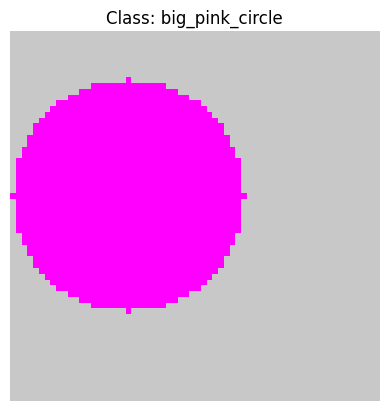

In [48]:
def show_random_image_from_loader(loader):
    # Get a random batch
    images, labels = next(iter(loader))
    # Select a random index from the batch
    rand_index = random.randint(0, len(images) - 1)
    # Get the image and label
    image = images[rand_index]
    label = labels[rand_index]

    # Convert the image to a format that can be displayed
    image = image.permute(1, 2, 0).numpy()  # From CxHxW to HxWxC
    image = np.clip(image, 0, 1)  # Clip values to range [0, 1] for display

    # Get class name from the dataset's class dictionary
    class_name = train_dataset.classes[label]

    # Plot the image with the class name as title
    plt.imshow(image)
    plt.title(f"Class: {class_name}")
    plt.axis('off')
    plt.show()

# Use the function to display a random image
show_random_image_from_loader(train_loader)

In [49]:
class CircleClassifier(nn.Module):
    def __init__(self):
        super(CircleClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 64),
            nn.ReLU(),
            nn.Linear(64, 4) 
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model = CircleClassifier()

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [51]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/4], Loss: 0.1586
Epoch [2/4], Loss: 0.0416
Epoch [3/4], Loss: 0.0278
Epoch [4/4], Loss: 0.0336


Validation Accuracy: 99.90%


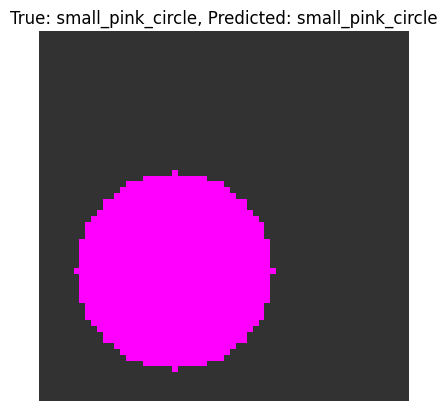

In [52]:
idx_to_class = {v: k for k, v in val_dataset.class_to_idx.items()}

total = 0
correct = 0

with torch.no_grad():
    all_images = []
    all_labels = []
    all_predicted = []
    
    for images, labels in val_loader:
        outputs = model(images) 
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_images.extend(images)
        all_labels.extend(labels)
        all_predicted.extend(predicted)

# Compute accuracy
accuracy = 100 * correct / total
print(f'Validation Accuracy: {accuracy:.2f}%')

# Select a random image
random_index = random.randint(0, len(all_images) - 1)
random_image = all_images[random_index]
true_label = all_labels[random_index].item()
predicted_label = all_predicted[random_index].item()

# Decode true and predicted labels
decoded_true_label = idx_to_class[true_label]
decoded_predicted_label = idx_to_class[predicted_label]

# Display the random image with true and predicted labels
plt.imshow(random_image.permute(1, 2, 0).numpy())
plt.title(f'True: {decoded_true_label}, Predicted: {decoded_predicted_label}')
plt.axis('off')
plt.show()